<a href="https://colab.research.google.com/github/Kdrakula/Fuzzy/blob/main/test_anfis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python: 3.11.14
TF: 2.15.0

In [8]:
import sys
sys.path.append('/content/drive/MyDrive')

import pandas as pd
import numpy as np
import tensorflow as tf
import myanfis
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys

print("Python:",sys.version)

print("TF:", tf.__version__)
print("myanfis OK")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TF: 2.19.0
myanfis OK


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- WCZYTYWANIE DANYCH Z PLIKU sleeping_bags.csv (POPRAWIONE) ---

# 1. Wczytaj dane
df = pd.read_csv('sleeping_bags.csv', sep=';')

# 2. Czyszczenie danych (Wersja Robust)
# Najpierw konwersja na string
df['Cena [zł]'] = df['Cena [zł]'].astype(str)

# Usuwamy 'zł' niezależnie od tego, czy jest przed nim spacja zwykła czy twarda
df['Cena [zł]'] = df['Cena [zł]'].str.replace('zł', '', regex=False)

# Zamieniamy przecinek na kropkę
df['Cena [zł]'] = df['Cena [zł]'].str.replace(',', '.', regex=False)

# Usuwamy WSZYSTKIE białe znaki (zwykłe spacje, twarde spacje \xa0, tabulatory)
df['Cena [zł]'] = df['Cena [zł]'].str.replace(r'\s+', '', regex=True)

# Konwersja na float
df['Cena [zł]'] = pd.to_numeric(df['Cena [zł]'], errors='coerce')

# Wybór kolumn do modelu
selected_columns = ['Waga Wypełnienia [g]', 'CUIN', 'T-Comfort']
df_clean = df[selected_columns].dropna()

print(f"Liczba wierszy po czyszczeniu: {len(df_clean)}") # Powinno być ok. 100-110

X = df_clean[['Waga Wypełnienia [g]', 'CUIN']].values
y = df_clean[['T-Comfort']].values

# 3. Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Standaryzacja
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# 5. PRZYCINANIE DO BATCH_SIZE
BATCH_SIZE = 16

def trim_to_batch(data, batch_size):
    if len(data) < batch_size:
        return data # Zabezpieczenie, choć train_test_split powinien dać więcej
    rows_to_keep = (len(data) // batch_size) * batch_size
    return data[:rows_to_keep]

X_train = trim_to_batch(X_train, BATCH_SIZE)
y_train = trim_to_batch(y_train, BATCH_SIZE)
X_test = trim_to_batch(X_test, BATCH_SIZE)
y_test = trim_to_batch(y_test, BATCH_SIZE)

# Walidacja
X_val = X_test
y_val = y_test

print("Dane gotowe!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Dane gotowe!
X_train shape: (80, 2)
y_train shape: (80, 1)


In [ ]:

param = myanfis.fis_parameters(
    n_input=2,                # no. of Regressors
    n_memb=3,                 # no. of fuzzy memberships
    batch_size=16,            # 16 / 32 / 64 / ...  !!!!!!!!!! całkowicie dzieli zbiór danych
    memb_func='gaussian',      # 'gaussian' / 'gbellmf' / 'sigmoid'
    optimizer='adam',          # sgd / adam / ...
    # mse / mae / huber_loss / mean_absolute_percentage_error / ...
    loss=tf.keras.losses.MeanAbsoluteError(),
    n_epochs=100               # 10 / 25 / 50 / 100 / ...
)

In [ ]:
# inicjalizacja modelu ANFIS
fis = myanfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis')


In [ ]:
# kompilacja modelu
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss,
                  metrics=['mse']  # ['mae', 'mse']
                  )

In [ ]:
# dopasowanie modelu do danych treningowych
history = fis.fit(X_train, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_val, y_val),
                  # callbacks = [tensorboard_callback]  # for tensorboard
                  )


Epoch 1/100
5/5 [==============================] - 0s 18ms/step - loss: 0.4744 - mse: 0.3343 - val_loss: 0.3797 - val_mse: 0.2319
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4678 - mse: 0.3257 - val_loss: 0.3753 - val_mse: 0.2259
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4613 - mse: 0.3170 - val_loss: 0.3703 - val_mse: 0.2199
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4553 - mse: 0.3087 - val_loss: 0.3662 - val_mse: 0.2146
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4490 - mse: 0.3004 - val_loss: 0.3618 - val_mse: 0.2092
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4427 - mse: 0.2929 - val_loss: 0.3571 - val_mse: 0.2039
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4369 - mse: 0.2849 - val_loss: 0.3531 - val_mse: 0.1990
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4312 - mse: 0.2779 - va

Predykcja

In [ ]:
train_predictions = fis.model.predict(X_train, batch_size=param.batch_size) #!!!batch_size
predictions = fis.model.predict(X_test, batch_size=param.batch_size)

2/2 [==============================] - 0s 857us/step


Ocena modelu

<Axes: >

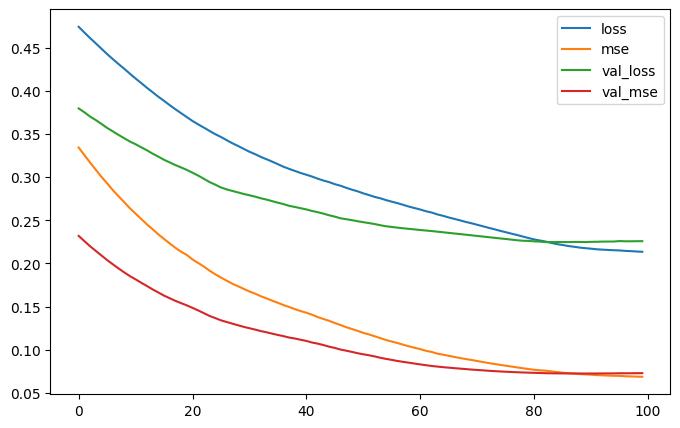

In [ ]:
# proces uczenia
loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

In [ ]:
# train
print('TRAIN')
print(f'mean_absolute_error: {mean_absolute_error(y_train, train_predictions)}')
print(f'mean_squared_error: {mean_squared_error(y_train, train_predictions)}')
# test
print('TEST')
print(f'mean_absolute_error: {mean_absolute_error(y_test, predictions)}')
print(f'mean_squared_error: {mean_squared_error(y_test, predictions)}')

TRAIN
mean_absolute_error: 0.21333735321072975
mean_squared_error: 0.06838861276196866
TEST
mean_absolute_error: 0.22416697469968186
mean_squared_error: 0.07290715550256398


Interpretacja modelu

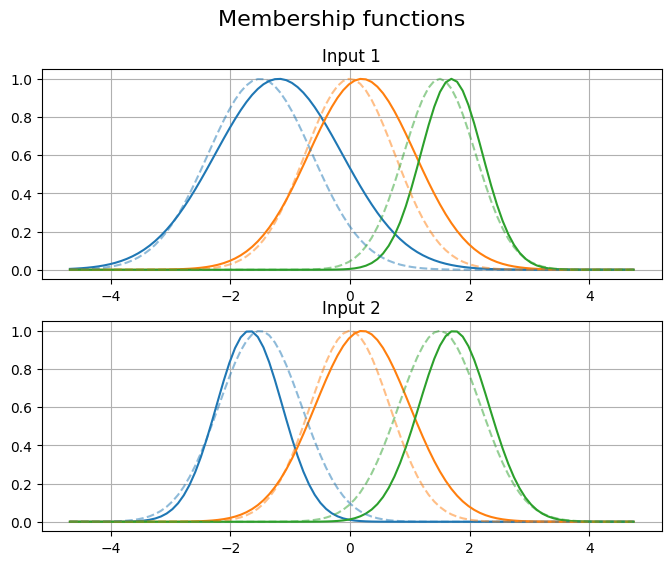

In [ ]:
# eval model
fis.plotmfs(show_initial_weights=True)

In [ ]:
# get premise parameters
premise_parameters = fis.model.get_layer('fuzzyLayer').get_weights()       # alternative
premise_parameters

# niebieski: input 1 - mu  |  input 2 - mu
# pomaranczowy: input 1 - mu  |  input 2 - mu  |
# niebieski: input 1 - mu  |  input 2 - mu
# zielony: input 1 - mu  |  input 2 - mu  |

# kolejna tablica - sigma

[array([[-1.1934832 , -1.6761858 ],
        [ 0.20165506,  0.21098042],
        [ 1.7028387 ,  1.7380699 ]], dtype=float32),
 array([[1.501002  , 0.7802369 ],
        [1.2641691 , 1.1201814 ],
        [0.73128664, 0.8295766 ]], dtype=float32)]

In [ ]:
fis.model.summary()

Model: "myanfis"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(16, 2)]                    0         []                            
                                                                                                  
 fuzzyLayer (FuzzyLayer)     (16, 3, 2)                   12        ['inputLayer[0][0]']          
                                                                                                  
 ruleLayer (RuleLayer)       (16, 9)                      0         ['fuzzyLayer[0][0]']          
                                                                                                  
 normLayer (NormLayer)       (16, 9)                      0         ['ruleLayer[0][0]']           
                                                                                            

y = ax1+ bx2 + c

In [ ]:
# get consequence paramters
bias = fis.bias
weights = fis.weights
conseq_parameters = fis.model.get_layer('defuzzLayer').get_weights()       # alternatywa
conseq_parameters

[array([[-1.5490401 ,  0.7417024 , -0.8088483 , -0.6446421 ,  0.15276204,
          1.3564728 , -0.11050999, -1.129251  , -0.26781842]],
       dtype=float32),
 array([[-0.685031  , -1.0731833 , -0.77891344,  1.1530153 ,  1.3222077 ,
         -0.56050014, -1.2924632 ,  0.2816042 , -0.11829327],
        [-1.7871289 ,  0.31837967, -1.1976585 ,  0.44259083, -0.20200059,
          0.57392055, -0.09681963, -0.58049285,  1.3623929 ]],
       dtype=float32)]

In [ ]:
# @title 🏕️ Sprawdź cenę śpiwora (Symulator)
# @markdown Wpisz parametry śpiwora, aby zobaczyć, ile zdaniem modelu powinien kosztować.

waga_wypelnienia_g = 2000 # @param {type:"number"}
CUIN = 1200 # @param {type:"number"}

import numpy as np

# 1. Przygotowanie danych wejściowych (surowych)
raw_input = np.array([[waga_wypelnienia_g, CUIN]])

# 2. Standaryzacja wejścia (tak jak przy uczeniu!)
# Używamy obiektu scaler_x, który został "nauczony" wcześniej
scaled_input = scaler_x.transform(raw_input)

# 3. Obejście problemu BATCH_SIZE
# Model myanfis wymaga, aby podać mu dokładnie tyle wierszy, ile wynosił batch_size (np. 16)
# Tworzymy macierz zer o wymiarach (BATCH_SIZE, 2)
# Zakładam, że zmienna BATCH_SIZE jest zdefiniowana w poprzednich komórkach (np. 16)
input_batch = np.zeros((BATCH_SIZE, 2))

# Wstawiamy Twój śpiwór jako pierwszy wiersz
input_batch[0] = scaled_input[0]

# 4. Predykcja
# verbose=0 wyłącza pasek postępu
predicted_batch_scaled = fis.model.predict(input_batch, batch_size=BATCH_SIZE, verbose=0)

# 5. Odwrócenie skalowania wyniku (StandardScaler -> PLN)
# Wynik też jest w batchu, musimy go odczarować scalerem_y
predicted_batch_real = scaler_y.inverse_transform(predicted_batch_scaled)

# 6. Wyciągnięcie wyniku dla naszego śpiwora (pierwszy wiersz)
predicted_price = predicted_batch_real[0][0]

print("-" * 30)
print(f"Dla parametrów:")
print(f"🎒 Waga: {waga_wypelnienia_g} g")
print(f"❄️ CUIN: {CUIN}")
print("-" * 30)
print(f"💰 T-Comfort: {predicted_price:.2f} C")
print("-" * 30)